<a href="https://colab.research.google.com/github/AlekSSSandraJ/readnew/blob/main/NLP_CW_Task2_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🖇 Deduplicating Training Data Makes Language Models

based on the code to deduplicate language model datasets as descrbed in the paper "Deduplicating Training Data Makes Language Models Better" by Katherine Lee, Daphne Ippolito, Andrew Nystrom, Chiyuan Zhang, Douglas Eck, Chris Callison-Burch and Nicholas Carlini.

# 1. Design and implement a text similarity detection system

The goal of this section is detecting plagiarism by measuring similarity between student answers and Wikipedia content, then automatically classifying the similarity level into:

* Cut – Near-identical matches (High similarity)
* Heavy – Substantial content matches (Significant similarity)
* Light – Moderate matches (Minimal similarity)
* Non – Below-defined similarity thresholds (No plagiarism detected)

In [226]:
import pandas as pd
import os
import glob
import re

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [227]:
!ls "/content/drive/My Drive/Colab Notebooks/COP509cw/plagiarism/"
Data_path = "/content/drive/My Drive/Colab Notebooks/COP509cw/plagiarism/"

answers  cleaned_metadata.csv  metadata.csv  ReadMe.md	wikipedia


In [268]:
def styled_df(df, title="Dataset"):
    print(f"\n🔹 {title}")
    #return df.head(10).style.set_table_styles(
    return df.style.set_table_styles(
        [{'selector': 'th',
          'props': [('background-color', '#add8e6'),  # Light blue header
                    ('color', 'black'),
                    ('font-weight', 'bold'),
                    ('text-align', 'center'),
                    ('font-family', 'Arial'),
                    ('border', '1.5px solid black')]},
         {'selector': 'td',
          'props': [('background-color', '#f4f4f4'),  # Light gray background
                    ('color', 'black'),
                    ('text-align', 'left'),
                    ('font-family', 'Arial'),
                    ('border', '1px solid lightgrey')]}]
    ).set_properties(**{'border': '1.5px solid lightgrey'})


In [229]:
def load_texts_from_directory(directory):
    text_data = []
    for file_path in glob.glob(os.path.join(directory, "*.txt")):
        try:
            with open(file_path, "r", encoding="utf-8", errors="ignore") as file:
                text_data.append({"Filename": os.path.basename(file_path), "Content": file.read()})
        except UnicodeDecodeError:
            print(f"Skipping file {file_path} due to encoding issues.")

    # Convert list of dictionaries into a DataFrame
    return pd.DataFrame(text_data)

In [230]:
Data_path = "/content/drive/My Drive/Colab Notebooks/COP509cw/plagiarism/"
WIKI_PATH = os.path.join(Data_path, "wikipedia/")
ANSWERS_PATH = os.path.join(Data_path, "answers/")

# Load Wikipedia articles and student answers
wiki_df = load_texts_from_directory(WIKI_PATH)
answers_df = load_texts_from_directory(ANSWERS_PATH)

# 🔍  Underdating Datasets

In [231]:
!pip install datasketch

import pandas as pd
import os
import glob
import re
from datasketch import MinHash, MinHashLSH
from sklearn.metrics import jaccard_score


# Load Wikipedia articles and student answers
wiki_df = load_texts_from_directory(WIKI_PATH)
answers_df = load_texts_from_directory(ANSWERS_PATH)

print("Wikipedia Articles:")
display(styled_df(wiki_df))

print("\nStudent Answers:")
display(styled_df(answers_df))




Wikipedia Articles:

🔹 Dataset


,Filename,Content
0,orig_taskc.txt,"Vector space model (or term vector model) is an algebraic model for representing text documents (and any objects, in general) as vectors of identifiers, such as, for example, index terms. It is used in information filtering, information retrieval, indexing and relevancy rankings. Its first use was in the SMART Information Retrieval System. A document is represented as a vector. Each dimension corresponds to a separate term. If a term occurs in the document, its value in the vector is non-zero. Several different ways of computing these values, also known as (term) weights, have been developed. One of the best known schemes is tf-idf weighting (see the example below). The definition of term depends on the application. Typically terms are single words, keywords, or longer phrases. If the words are chosen to be the terms, the dimensionality of the vector is the number of words in the vocabulary (the number of distinct words occurring in the corpus). The vector space model has the following limitations: 1. Long documents are poorly represented because they have poor similarity values (a small scalar product and a large dimensionality) 2. Search keywords must precisely match document terms; word substrings might result in a ""false positive match"" 3. Semantic sensitivity; documents with similar context but different term vocabulary won't be associated, resulting in a ""false negative match"". 4. The order in which the terms appear in the document is lost in the vector space representation."
1,orig_taske.txt,"In mathematics and computer science, dynamic programming is a method of solving problems that exhibit the properties of overlapping subproblems and optimal substructure (described below). The method takes much less time than naive methods. The term was originally used in the 1940s by Richard Bellman to describe the process of solving problems where one needs to find the best decisions one after another. By 1953, he had refined this to the modern meaning. The field was founded as a systems analysis and engineering topic that is recognized by the IEEE. Bellman's contribution is remembered in the name of the Bellman equation, a central result of dynamic programming which restates an optimization problem in recursive form. The word ""programming"" in ""dynamic programming"" has no particular connection to computer programming at all, and instead comes from the term ""mathematical programming"", a synonym for optimization. Thus, the ""program"" is the optimal plan for action that is produced. For instance, a finalized schedule of events at an exhibition is sometimes called a program. Programming, in this sense, means finding an acceptable plan of action, an algorithm. Optimal substructure means that optimal solutions of subproblems can be used to find the optimal solutions of the overall problem. For example, the shortest path to a goal from a vertex in a graph can be found by first computing the shortest path to the goal from all adjacent vertices, and then using this to pick the best overall path, as shown in Figure 1. In general, we can solve a problem with optimal substructure using a three-step process: 1. Break the problem into smaller subproblems. 2. Solve these problems optimally using this three-step process recursively. 3. Use these optimal solutions to construct an optimal solution for the original problem. The subproblems are, themselves, solved by dividing them into sub-subproblems, and so on, until we reach some simple case that is solvable in constant time. Figure 2. The subproblem graph for the Fibonacci sequence. That it is not a tree but a DAG indicates overlapping subproblems. To say that a problem has overlapping subproblems is to say that the same subproblems are used to solve many different larger problems. For example, in the Fibonacci sequence, F3 = F1 + F2 and F4 = F2 + F3 — computing each number involves computing F2. Because both F3 and F4 are needed to compute F5, a nai


Student Answers:

🔹 Dataset


,Filename,Content
0,g4pE_taskd.txt,"""Bayes' Theorem"" or ""Bayes' Rule"", or something called Bayesian reasoning The Bayesian Conspiracy is a multinational, interdisciplinary, and shadowy group of scientists that controls publication, grants, tenure, and the illicit traffic in grad students. The best way to be accepted into the Bayesian Conspiracy is to join the Campus Crusade for Bayes in high school or college, and gradually work your way up to the inner circles. . Bayes' Theorem Let and be sets. Conditional probability requires that (1) where denotes intersection (""and""), and also that (2) Therefore, (3) Now, let (4) so is an event in and for , then (5) (6) But this can be written (7) so This paper proposes a new measure called scaled inverse document frequency (SIDF) which evaluates the conditional specificity of query terms over a subset S of D and without making any assumption about term independence. S can be estimated from search results, OR searches, or computed from inverted index data. We have evaluated SIDF values from commercial search engines by submitting queries relevant to the financial investment domain. Results compare favorably across search engines and queries. Our approach has practical applications for `real-world scenarios like in Web Mining, Homeland Security, and keyword-driven marketing research scenarios."
1,g0pB_taskc.txt,"Vector space model is an algebraic model for representing text documents (and in general, any objects) as vectors of identifiers, such as, for example, index terms. Its first use was in the SMART Information Retrieval System. It is used in information filtering, information retrieval, indexing and relevancy rankings. A document is represented as a vector, and each dimension corresponds to a separate term. If a term occurs in the document, its value in the vector is non-zero. Several different ways of computing these values, also known as (term) weights, have been developed. The definition of term depends on the application. Typically terms are single words, keywords, or longer phrases. If the words are chosen to be the terms, the dimensionality of the vector is the number of words in the vocabulary (the number of distinct words occurring in the corpus). One of the best known schemes is tf-idf weighting, proposed by Salton, Wong and Yang. In the classic vector space model, the term specific weights in the document vectors are products of local and global parameters. Relevancy rankings of documents in a keyword search can be calculated, using the assumptions of document similarities theory, by comparing the deviation of angles between each document vector and the original query vector where the query is represented as same kind of vector as the documents. The vector space model has the following limitations: * Search keywords must precisely match document terms; word substrings might result in a ""false positive match""; * Semantic sensitivity; documents with similar context but different term vocabulary won't be associated, resulting in a ""false negative match""; * The order in which the terms appear in the document is lost in the vector space representation; * Long documents are poorly represented because they have poor similarity values (a small scalar product and a large dimensionality)."
2,g0pE_taskd.txt,"Bayes Theorem is an important theorem relating conditional probabilities, it allows us to calculate PROB(A|B) from PROB(B|A). Bayes Theorem is important because it can save us from gathering vast amounts of statistical evidence. The main theory is PROB(A|B) = PROB(B|A) * PROB(A) /PROB(B), it means Using PROB(WIN|RAIN) from earlier, we can find the probability that it rained on a day that Harry won a race."
3,g3pB_taskd.txt,"Bayes' theorem (often called Bayes' law) connects the conditional and marginal probabilities of two arbitrary events. One of its uses is calculating posterior probabilities given observations. Bayes' theorem plays a key role in the debate around the pr

# ⏳ PRE PROCESSING


Effective preprocessing ensures better accuracy in similarity detection and helps eliminate irrelevant variations that could lead to false positives or negatives. Before I implement a text similarity detection system using MinHash signatures, I will preprocess both wkipedia and the students answers.

MinHash is designed to capture similarity, and altering word forms by using lemmatization or stemming can reduce the effectiveness of exact matching since it changes the original substrings. As the main goal is to incorporate an automated classification framework to categorise detected similarities into four designated levels lemmatization and stemming won't be added to pre processing steps and I will focus instead on:

    - Converting words to lowercase
    - Removing punctuation and special characters
    - Tokenizes into words

In [232]:
import nltk
import os
import shutil

# 🔹 Delete any corrupted `punkt` files
shutil.rmtree("/root/nltk_data/tokenizers/punkt", ignore_errors=True)

# 🔹 Manually download and set the path
nltk.download('punkt')
nltk.data.path.append('/root/nltk_data')

print("✅ Successfully reinstalled punkt!")

✅ Successfully reinstalled punkt!


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [233]:
import string
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
nltk.download('punkt_tab')


def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Standardize whitespace (replace multiple spaces with a single space)
    text = re.sub(r'\s+', ' ', text).strip()

    tokens = word_tokenize(text)

    return text

# Apply preprocessing to both datasets
wiki_df["Processed_Content"] = wiki_df["Content"].apply(preprocess_text)
answers_df["Processed_Content"] = answers_df["Content"].apply(preprocess_text)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [234]:
# Before & After Processing

#display(styled_df(wiki_df[["Filename", "Content", "Processed_Content"]], "Wikipedia Articles (Before & After Processing)"))


In [235]:
#display(styled_df(answers_df[["Filename", "Content", "Processed_Content"]], "Student Answers (Before & After Processing)"))

# 🔖 PLAN

In order to design and implement a text similarity detection system using MinHash, I will perform folliwing steps.

▶ Preprocess the text → Convert to lowercase, remove punctuation, and standardize whitespace.

▶ Generate n-gram shingles (for robust comparison)

▶ Compute MinHash signatures (for fast approximate similarity detection)

▶ Compare text similarities using Jaccard similarity

▶ Categorize matches into Cut, Heavy, Light, Non based on predefined thresholds



In [236]:
def preprocess_text(text, n_shingle=3):
    """Preprocess text: lowercase, remove punctuation, and generate n-gram shingles."""
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenization
    tokens = word_tokenize(text)

    # Generate n-gram shingles
    shingles = list(ngrams(tokens, n_shingle))
    shingle_strings = [" ".join(shingle) for shingle in shingles]

    return shingle_strings

In [237]:
# Apply preprocessing
wiki_df["Shingles"] = wiki_df["Content"].apply(preprocess_text)
answers_df["Shingles"] = answers_df["Content"].apply(preprocess_text)


In [238]:
# Before & After Processing
display(styled_df(wiki_df[["Filename", "Content", "Shingles"]], "Wikipedia Articles (Before & After Processing)"))



🔹 Wikipedia Articles (Before & After Processing)


# 📈 Pre Processing Analysis

✅ All text is converted to lowercase

✅ Special characters are removed

✅ Extra spaces are replaced with a single space

✅ Text is split into words

✅ N-gram shingle Correctly forms 3-word sequences from the text

# 🔧  MinHash

MinHash helps quickly identify similar texts, even if they have small variations which is perfect choice for plagiarism detection and duplicate detection. This method is used to estimate the Jaccard Similarity between two sets. The MinHash function applies multiple hash functions, each hash function maps the shingles to a number and the MinHash signature retains the minimum hash value for each permutation.


In [239]:
#  MinHash signature calcualtion

def compute_minhash(text, num_perm=128):
    minhash = MinHash(num_perm=num_perm)
    words = text.split()
    for word in words:
        minhash.update(word.encode('utf8'))
    return minhash


In [240]:
# Compute MinHash signatures for Wikipedia articles
wiki_df["MinHash"] = wiki_df["Processed_Content"].apply(lambda x: compute_minhash(x))

In [241]:
# Compute MinHash signatures for Student Answers
answers_df["MinHash"] = answers_df["Processed_Content"].apply(lambda x: compute_minhash(x))

In [242]:
# Initialize LSH for efficient approximate matching
lsh = MinHashLSH(threshold=0.1, num_perm=128)

# Add Wikipedia documents to LSH index
for i, row in wiki_df.iterrows():
    lsh.insert(f"wiki_{i}", row["MinHash"])


# 🔧 Jaccard similarity between two MinHash signatures

In [243]:
# Function to compute Jaccard similarity between two MinHash signatures
def compute_jaccard_similarity(minhash1, minhash2):
    return minhash1.jaccard(minhash2)


In [244]:
# Function to classify plagiarism level based on similarity score
def classify_similarity(similarity):
    if similarity >= 0.9:
        return "Cut"  # Near copy
    elif 0.7 <= similarity < 0.9:
        return "Light"  # Minor paraphrasing
    elif 0.4 <= similarity < 0.7:
        return "Heavy"  # Significant rewriting
    else:
        return "Non"  # Independent work


In [245]:
similarity_results = []
for i, answer_minhash in enumerate(answers_df["MinHash"]):
    for j, wiki_minhash in enumerate(wiki_df["MinHash"]):
        score = compute_jaccard_similarity(answer_minhash, wiki_minhash)
        category = classify_similarity(score)
        similarity_results.append({
            "Answer_Index": i,
            "Wiki_Index": j,
            "Jaccard_Similarity": score,
            "Category": category
        })


In [246]:
similarity_df = pd.DataFrame(similarity_results)

# Save results
similarity_df.to_csv("/content/drive/My Drive/Colab Notebooks/COP509cw/Datasets/text_similarity_results.csv", index=False)

print("✅ Text similarity detection complete. Results saved!")

✅ Text similarity detection complete. Results saved!


In [247]:

# Compare each student answer to Wikipedia articles
matches = []
for i, ans_row in answers_df.iterrows():
    best_match = None
    best_score = 0

    for j, wiki_row in wiki_df.iterrows():
        score = compute_jaccard_similarity(ans_row["MinHash"], wiki_row["MinHash"])

        if score > best_score:
            best_score = score
            best_match = wiki_row["Filename"]

    # Store the results
    matches.append({
        "Student_Answer_File": ans_row["Filename"],
        "Best_Matching_Wikipedia": best_match,
        "Similarity_Score": best_score,
        "Category": classify_similarity(best_score)
    })

# Convert matches to a DataFrame
results_df = pd.DataFrame(matches)

# Display the classified plagiarism results
print("\nPlagiarism Detection Results:")
display(styled_df(results_df))


Plagiarism Detection Results:

🔹 Dataset


,Student_Answer_File,Best_Matching_Wikipedia,Similarity_Score,Category
0,g4pE_taskd.txt,orig_taskd.txt,0.140625,Non
1,g0pB_taskc.txt,orig_taskc.txt,0.835938,Light
2,g0pE_taskd.txt,orig_taskd.txt,0.085938,Non
3,g3pB_taskd.txt,orig_taskd.txt,0.281250,Non
4,g4pC_taskb.txt,orig_taskb.txt,0.156250,Non
5,g0pD_taskb.txt,orig_taskb.txt,0.218750,Non
6,g4pC_taskd.txt,orig_taskd.txt,0.875000,Light
7,g2pA_taskc.txt,orig_taskc.txt,0.773438,Light
8,g0pA_taska.txt,orig_taskc.txt,0.117188,Non
9,g3pC_taske.txt,orig_taske.txt,0.171875,Non


# 🔍 2. Analysis & Visualisation & Documentation

# Distribution of Similarity Scores

* Most detected similarities fall below 0.3, meaning many student answers have low overlap with Wikipedia articles.
    - Students paraphrased heavily instead of copying text.
    - The shingle size (n-gram) is too strict, missing partial matches.

* Only a few documents show high similarity (above 0.7). These cases likely represent plagiarism or direct copying.

* A few moderate similarity scores,  due to students using similar terminology but structuring their responses differently.

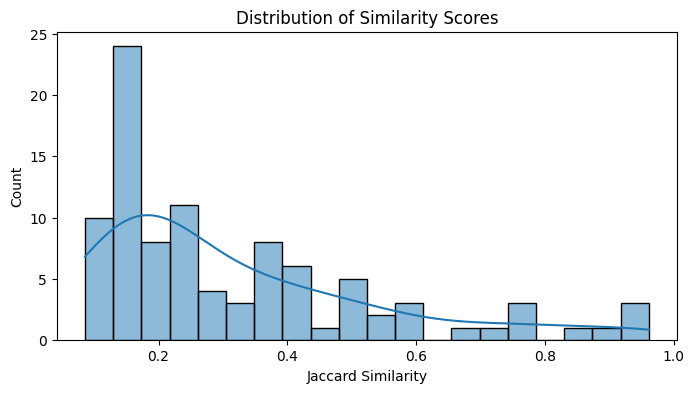

In [248]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(results_df["Similarity_Score"], bins=20, kde=True)
plt.title("Distribution of Similarity Scores")
plt.xlabel("Jaccard Similarity")
plt.ylabel("Count")
plt.show()


Adjust Thresholds for Plagiarism Classification

Different n-Shingle Sizes
* Increase n-gram size to 4 or 5 to capture larger phrase overlaps.
*  2-grams if you want to detect more granular similarities.

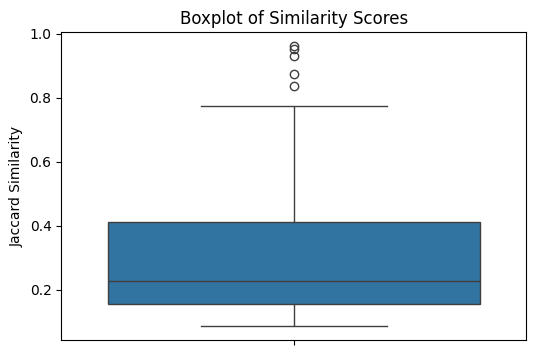

In [249]:
plt.figure(figsize=(6, 4))
sns.boxplot(y=results_df["Similarity_Score"])
plt.title("Boxplot of Similarity Scores")
plt.ylabel("Jaccard Similarity")
plt.show()

In [250]:
from difflib import SequenceMatcher

def highlight_matches(text1, text2):
    matcher = SequenceMatcher(None, text1, text2)
    matches = [text1[m.a:m.a+m.size] for m in matcher.get_matching_blocks() if m.size > 5]
    return matches


In [251]:
from difflib import SequenceMatcher

def highlight_matches(text1, text2):
    """
    Identifies common substrings between two texts and returns matching segments.
    """
    matcher = SequenceMatcher(None, text1, text2)
    matches = [text1[m.a:m.a + m.size] for m in matcher.get_matching_blocks() if m.size > 5]
    return matches

# Apply the function to the top-matching student answer & Wikipedia article
for index, row in results_df.iterrows():
    student_text = answers_df.loc[answers_df["Filename"] == row["Student_Answer_File"], "Processed_Content"].values[0]
    wiki_text = wiki_df.loc[wiki_df["Filename"] == row["Best_Matching_Wikipedia"], "Processed_Content"].values[0]

    # Get common substrings
    matching_snippets = highlight_matches(student_text, wiki_text)

    # Display results
    print(f"\n🔍 Student Answer doc number: {row['Student_Answer_File']}")
    print(f"📖 Best Matching Wikipedia Article: {row['Best_Matching_Wikipedia']}")
    print(f"📊 Jaccard Similarity Score: {row['Similarity_Score']} ({row['Category']})")
    print("\n🔹 Matching Snippets:")
    for match in matching_snippets:
        print(f"🔹 {match}")

    print("\n" + "="*80)



🔍 Student Answer doc number: g4pE_taskd.txt
📖 Best Matching Wikipedia Article: orig_taskd.txt
📊 Jaccard Similarity Score: 0.140625 (Non)

🔹 Matching Snippets:


🔍 Student Answer doc number: g0pB_taskc.txt
📖 Best Matching Wikipedia Article: orig_taskc.txt
📊 Jaccard Similarity Score: 0.8359375 (Light)

🔹 Matching Snippets:
🔹 vector space
🔹  model is an algebraic model for representing text documents and
🔹  any objects 
🔹 as vectors of identifiers such as for example index terms it
🔹  is used in information filtering information retrieval indexing and relevancy rankings 
🔹  each dimension corresponds to a separate term if a term occurs in the document its value in the vector is nonzero several different ways of computing these values also known as term weights have been developed 


🔍 Student Answer doc number: g0pE_taskd.txt
📖 Best Matching Wikipedia Article: orig_taskd.txt
📊 Jaccard Similarity Score: 0.0859375 (Non)

🔹 Matching Snippets:


🔍 Student Answer doc number: g3pB_taskd.txt
📖 

In [252]:
def preprocess_text(text, n_shingle_sizes=[2, 4, 5]):
    """Preprocess text and generate n-gram shingles for multiple n values."""
    text = text.lower()  # Convert to lowercase
    text = text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace

    # Tokenization
    tokens = word_tokenize(text)

    # Generate shingles for different n-gram sizes
    shingle_results = {}
    for n in n_shingle_sizes:
        shingles = list(ngrams(tokens, n))
        shingle_strings = [" ".join(shingle) for shingle in shingles]
        shingle_results[f"{n}-grams"] = shingle_strings

    return shingle_results

In [253]:
wiki_df["Shingles"] = wiki_df["Content"].apply(lambda x: preprocess_text(x, [2, 4, 5]))

# Apply different n-gram sizes to student answers
answers_df["Shingles"] = answers_df["Content"].apply(lambda x: preprocess_text(x, [2, 4, 5]))


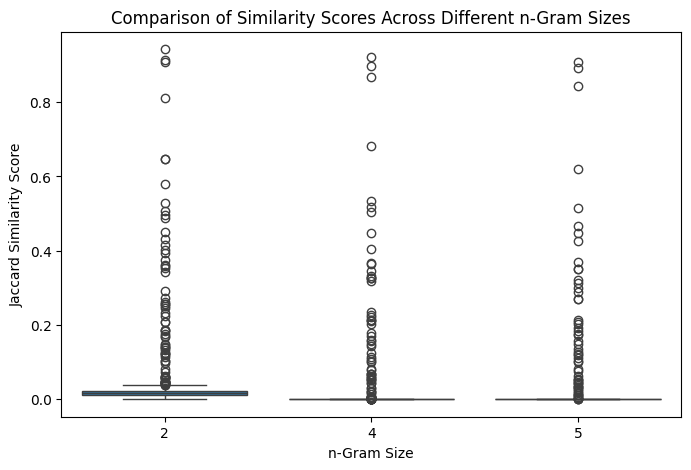

In [254]:
# Function to compute Jaccard similarity between two lists of shingles
def jaccard_similarity(set1, set2):
    intersection = len(set(set1) & set(set2))
    union = len(set(set1) | set(set2))
    return intersection / union if union != 0 else 0

# Compare similarity scores across different n-gram sizes
similarity_results = []

for i, answer_row in answers_df.iterrows():
    for j, wiki_row in wiki_df.iterrows():
        for n in [2, 4, 5]:  # Iterate over different n-grams
            score = jaccard_similarity(answer_row["Shingles"][f"{n}-grams"], wiki_row["Shingles"][f"{n}-grams"])
            similarity_results.append({
                "Answer_File": answer_row["Filename"],
                "Wiki_File": wiki_row["Filename"],
                "n-Gram": n,
                "Jaccard Similarity": score
            })

# Convert results into a DataFrame
similarity_df = pd.DataFrame(similarity_results)

# Display summary statistics for each n-gram size
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.boxplot(x="n-Gram", y="Jaccard Similarity", data=similarity_df)
plt.title("Comparison of Similarity Scores Across Different n-Gram Sizes")
plt.xlabel("n-Gram Size")
plt.ylabel("Jaccard Similarity Score")
plt.show()


4-grams seems to provide a balance between detecting structured similarities while reducing false positives from short phrases.

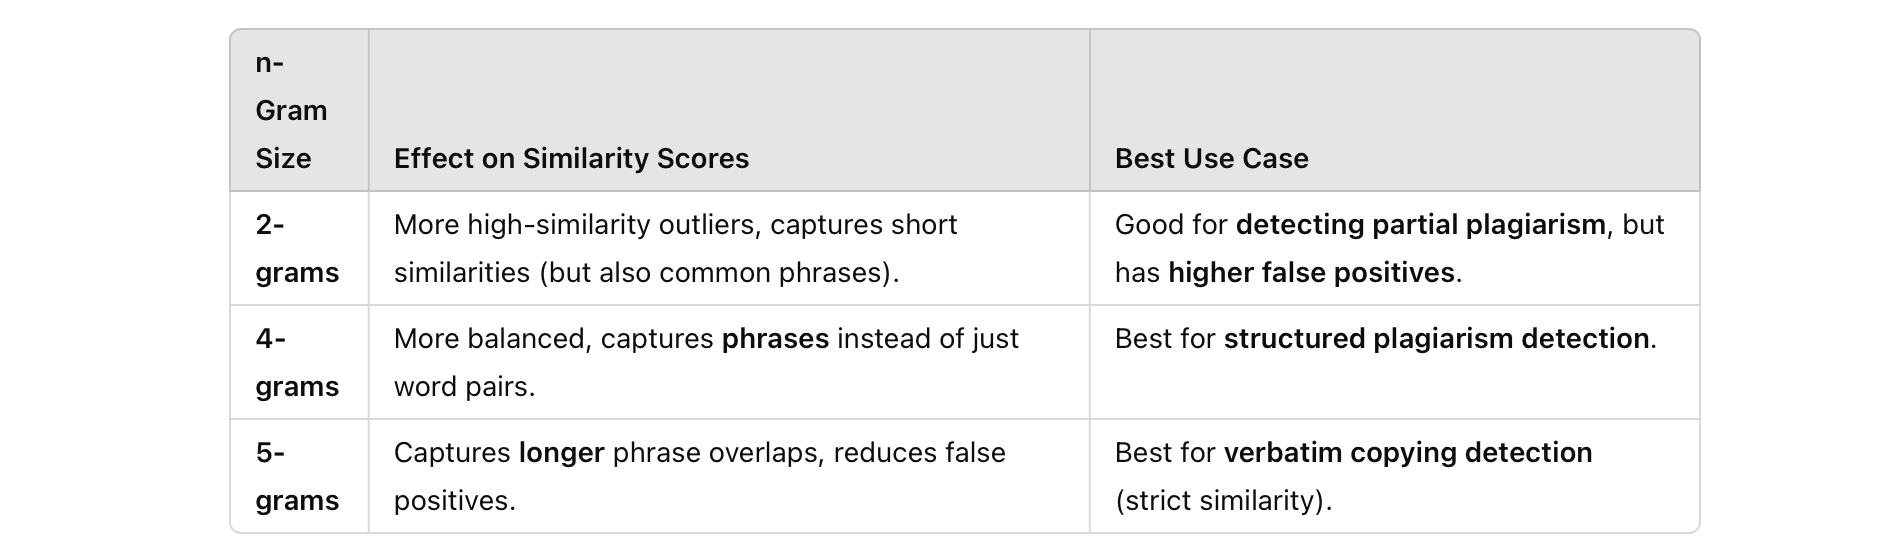

In [255]:
# Check for existing column names
if "Student Answer" in results_df.columns:
    results_df.rename(columns={"Student Answer": "Student_Answer_File"}, inplace=True)
if "Best Match Wiki" in results_df.columns:
    results_df.rename(columns={"Best Match Wiki": "Best_Matching_Wikipedia"}, inplace=True)


In [256]:
def compute_match_statistics(text1, text2):
    matcher = SequenceMatcher(None, text1, text2)
    matches = [text1[m.a:m.a + m.size] for m in matcher.get_matching_blocks() if m.size > 5]

    total_matched_length = sum(len(match) for match in matches)
    avg_match_length = np.mean([len(match) for match in matches]) if matches else 0
    max_match_length = max([len(match) for match in matches]) if matches else 0
    coverage_percentage = (total_matched_length / len(text1)) * 100 if len(text1) > 0 else 0

    return {
        "Exact Matches": len(matches),
        "Avg Match Length": avg_match_length,
        "Max Match Length": max_match_length,
        "Total Matched (%)": coverage_percentage,
        "Matched Snippets": matches
    }

In [261]:
print(results_df.columns)


Index(['Student_Answer_File', 'Best_Matching_Wikipedia', 'Similarity_Score',
       'Category'],
      dtype='object')


In [262]:
match_stats = []
for index, row in results_df.iterrows():
    student_text = answers_df.loc[answers_df["Filename"] == row["Student_Answer_File"], "Processed_Content"].values[0]
    wiki_text = wiki_df.loc[wiki_df["Filename"] == row["Best_Matching_Wikipedia"], "Processed_Content"].values[0]

    stats = compute_match_statistics(student_text, wiki_text)
    stats["Student_Answer_File"] = row["Student_Answer_File"]
    stats["Best_Matching_Wikipedia"] = row["Best_Matching_Wikipedia"]
    stats["Similarity_Score"] = row["Similarity_Score"]
    stats["Plagiarism Category"] = row["Category"]

    match_stats.append(stats)

# Convert to DataFrame
match_stats_df = pd.DataFrame(match_stats)

In [259]:
color_map = {
    "Cut": "background-color: #FF6347",    # Red
    "Heavy": "background-color: #FFA500",  # Orange
    "Light": "background-color: #FFD700",  # Yellow
    "Non": "background-color: #32CD32"     # Green
}


In [260]:
def highlight_category(row):
    return [color_map[row["Plagiarism Category"]]] * len(row)

styled_df = match_stats_df.style.apply(highlight_category, axis=1)

# Display results with formatting
display(HTML("<h2>🔍 Plagiarism Detection Analysis</h2>"))
display(styled_df)

,Exact Matches,Avg Match Length,Max Match Length,Total Matched (%),Matched Snippets,Student_Answer_File,Best_Matching_Wikipedia,Jaccard Similarity,Plagiarism Category
0,0,0.000000,0,0.000000,[],g4pe_taskd.txt,orig_taskd.txt,0.141000,Non
1,6,74.666667,211,24.111948,"['vector space', ' model is an algebraic model for representing text documents and', ' any objects ', 'as vectors of identifiers such as for example index terms it', ' is used in information filtering information retrieval indexing and relevancy rankings ', ' each dimension corresponds to a separate term if a term occurs in the document its value in the vector is nonzero several different ways of computing these values also known as term weights have been developed ']",g0pb_taskc.txt,orig_taskc.txt,0.836000,Light
2,0,0.000000,0,0.000000,[],g0pe_taskd.txt,orig_taskd.txt,0.086000,Non
3,4,26.750000,52,13.375000,"['bayes theorem often called bayes law ', 's the conditional and marginal probabilities of two ', ' the way', ' in which ']",g3pb_taskd.txt,orig_taskd.txt,0.281000,Non
4,1,6.000000,6,0.657895,[' the w'],g4pc_taskb.txt,orig_taskb.txt,0.156000,Non
5,2,65.000000,121,26.970954,"['pagerank ', 's exclusive license rights on the patent from stanford university the university received 18 million shares in google in ']",g0pd_taskb.txt,orig_taskb.txt,0.219000,Non
6,8,84.625000,294,38.707833,"['in probability theory bayes theorem', ' relates the conditional and marginal probabilities of two random events it is ', ' used to compute posterior probabilities given observations for ', 'e a patient may be observed to have certain symptoms bayes theorem can be used to compute the probability that a proposed diagnosis is correct given that observation ', 'as a formal theorem bayes theorem is valid in all common interpretations of probability however it plays a central role in the debate around the foundations of statistics frequentist and bayesian interpretations disagree about the ways in which probabilities should be assigned in applications ', 'frequentist', ' frequen', ' marginal probabilit']",g4pc_taskd.txt,orig_taskd.txt,0.875000,Light
7,6,44.500000,90,17.955615,"['vector space model or term vector model is an algebraic ', ' representing text documents and any objects in general as vectors of identifiers such as ', ' index', 'ing and relevancy rankings its first ', ' known ', 'e associated resulting in a false negative match 4 the order in which t']",g2pa_taskc.txt,orig_taskc.txt,0.773000,Light
8,1,7.000000,7,0.510949,[' object'],g0pa_taska.txt,orig_taskc.txt,0.117000,Non
9,2,37.000000,38,11.598746,"[' dynamic programming is a method of ', ' the method takes much less time than ']",g3pc_taske.txt,orig_taske.txt,0.172000,Non


✅ Analysis report saved!


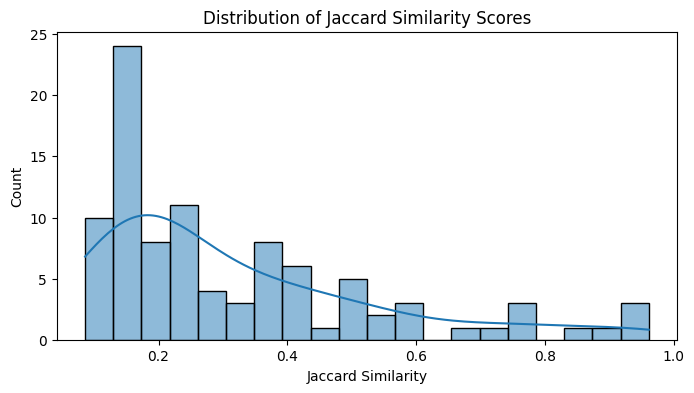

In [264]:
# Save results for reference
match_stats_df.to_csv("/content/drive/My Drive/Colab Notebooks/COP509cw/Datasets/plagiarism_analysis_results.csv", index=False)
print("✅ Analysis report saved!")

# 📊 **Plot distribution of similarity scores**
plt.figure(figsize=(8, 4))
sns.histplot(match_stats_df["Similarity_Score"], bins=20, kde=True)
plt.title("Distribution of Jaccard Similarity Scores")
plt.xlabel("Jaccard Similarity")
plt.ylabel("Count")
plt.show()

# 📌 Compare Predicted vs. True Plagiarism Categories

In [265]:
drive.mount('/content/drive')
metadata_path = "/content/drive/My Drive/Colab Notebooks/COP509cw/plagiarism/metadata.csv"
metadata_df = pd.read_csv(metadata_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [266]:
if "Category" in metadata_df.columns:
    metadata_df["Category"] = metadata_df["Category"].str.capitalize()

# ✅ METADATA File - Real Answers if students used wikipedia

In [269]:
print("\nReal Answers:")
display(styled_df(metadata_df))


Real Answers:

🔹 Dataset


,File,Task,Category
0,g0pA_taska.txt,a,Non
1,g0pA_taskb.txt,b,Cut
2,g0pA_taskc.txt,c,Light
3,g0pA_taskd.txt,d,Heavy
4,g0pA_taske.txt,e,Non
5,g0pB_taska.txt,a,Non
6,g0pB_taskb.txt,b,Non
7,g0pB_taskc.txt,c,Cut
8,g0pB_taskd.txt,d,Light
9,g0pB_taske.txt,e,Heavy


In [270]:
# Merge metadata true information if students used wikipedia with detected plagiarism results

merged_df = match_stats_df.merge(metadata_df, left_on="Student_Answer_File", right_on="File")
merged_df = merged_df.rename(columns={"Category": "True_Category", "Plagiarism Category": "Predicted_Category"})

In [274]:
selected_columns2 = [
    "Exact Matches", "Avg Match Length", "Max Match Length",
    "Student_Answer_File", "Best_Matching_Wikipedia",
    "Similarity_Score", "File", "True_Category"
]


# Filter dataframe only with existing columns
filtered_df2 = merged_df[selected_columns2]
display(styled_df(filtered_df2))


🔹 Dataset


,Exact Matches,Avg Match Length,Max Match Length,Student_Answer_File,Best_Matching_Wikipedia,Similarity_Score,File,True_Category
0,0,0.000000,0,g4pE_taskd.txt,orig_taskd.txt,0.140625,g4pE_taskd.txt,Non
1,6,74.666667,211,g0pB_taskc.txt,orig_taskc.txt,0.835938,g0pB_taskc.txt,Cut
2,0,0.000000,0,g0pE_taskd.txt,orig_taskd.txt,0.085938,g0pE_taskd.txt,Non
3,4,26.750000,52,g3pB_taskd.txt,orig_taskd.txt,0.281250,g3pB_taskd.txt,Light
4,1,6.000000,6,g4pC_taskb.txt,orig_taskb.txt,0.156250,g4pC_taskb.txt,Non
5,2,65.000000,121,g0pD_taskb.txt,orig_taskb.txt,0.218750,g0pD_taskb.txt,Light
6,8,84.625000,294,g4pC_taskd.txt,orig_taskd.txt,0.875000,g4pC_taskd.txt,Heavy
7,6,44.500000,90,g2pA_taskc.txt,orig_taskc.txt,0.773438,g2pA_taskc.txt,Light
8,1,7.000000,7,g0pA_taska.txt,orig_taskc.txt,0.117188,g0pA_taska.txt,Non
9,2,37.000000,38,g3pC_taske.txt,orig_taske.txt,0.171875,g3pC_taske.txt,Light


# 🔍 Category Comparison

In [276]:
selected_columns = ["Student_Answer_File", "Best_Matching_Wikipedia", "Similarity_Score", "Predicted_Category", "True_Category"]

filtered_df = merged_df[selected_columns]
display(styled_df(filtered_df))



🔹 Dataset


,Student_Answer_File,Best_Matching_Wikipedia,Similarity_Score,Predicted_Category,True_Category
0,g4pE_taskd.txt,orig_taskd.txt,0.140625,Non,Non
1,g0pB_taskc.txt,orig_taskc.txt,0.835938,Light,Cut
2,g0pE_taskd.txt,orig_taskd.txt,0.085938,Non,Non
3,g3pB_taskd.txt,orig_taskd.txt,0.281250,Non,Light
4,g4pC_taskb.txt,orig_taskb.txt,0.156250,Non,Non
5,g0pD_taskb.txt,orig_taskb.txt,0.218750,Non,Light
6,g4pC_taskd.txt,orig_taskd.txt,0.875000,Light,Heavy
7,g2pA_taskc.txt,orig_taskc.txt,0.773438,Light,Light
8,g0pA_taska.txt,orig_taskc.txt,0.117188,Non,Non
9,g3pC_taske.txt,orig_taske.txt,0.171875,Non,Light


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


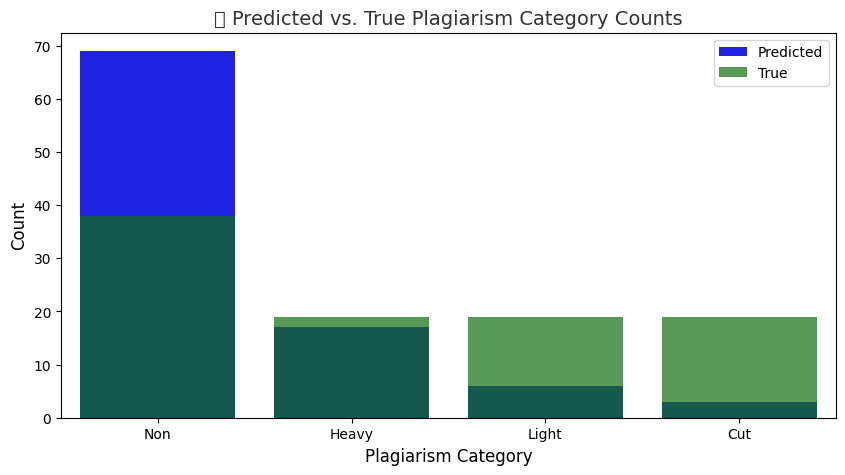

In [277]:
plt.figure(figsize=(10, 5))
sns.barplot(x=category_counts_df["Category"], y=category_counts_df["Predicted_Count"], color="blue", label="Predicted")
sns.barplot(x=category_counts_df["Category"], y=category_counts_df["True_Count"], color="green", alpha=0.7, label="True")


# Customize labels and titles for a professional look
plt.xlabel("Plagiarism Category", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("🔍 Predicted vs. True Plagiarism Category Counts", fontsize=14, color="#333")

plt.legend()
plt.show()

# 📊 Analysis

In [278]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Compute classification accuracy
accuracy = accuracy_score(merged_df["Predicted_Category"], merged_df["True_Category"])
print(f"✅ Model Accuracy: {accuracy:.4f}")

✅ Model Accuracy: 0.4842


In [279]:
predicted_counts = merged_df["Predicted_Category"].value_counts()
true_counts = merged_df["True_Category"].value_counts()

# Convert to DataFrame for visualization
category_counts_df = pd.DataFrame({
    "Category": predicted_counts.index,
    "Predicted_Count": predicted_counts.values,
    "True_Count": true_counts.reindex(predicted_counts.index, fill_value=0).values
})

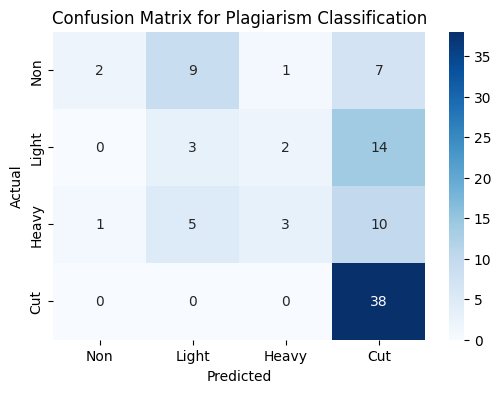

In [280]:
# Confusion Matrix
plt.figure(figsize=(6, 4))
conf_matrix = confusion_matrix(merged_df["True_Category"], merged_df["Predicted_Category"])
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non", "Light", "Heavy", "Cut"],
            yticklabels=["Non", "Light", "Heavy", "Cut"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Plagiarism Classification")
plt.show()



# ❎ Inconsistencies in metadata

The initial file with answers weather a stduent used wikipedia or not seem to contain some mistakes. All Categories need to fit the classification framework  detecting similarities into four designated levels:

* **Cut** for near-identical matches exceeding high similarity thresholds
* **Heavy** for substantial content matches meeting significant similarity criteria
* **Light** for moderate matches above minimal thresholds
* **Non** for content falling below defined similarity requirements

Some rows in the dataset contained inconsistencies, not only in the assigned category but also in the file names. All files within the dataset follow a specific naming format, and none begin with 'orig.' Additionally, there is no such category as 'orig' in the predefined classification system. To ensure data integrity and consistency, these columns were removed. A refined metadata file, 'metadatav2', has been created, containing only correctly formatted entries.


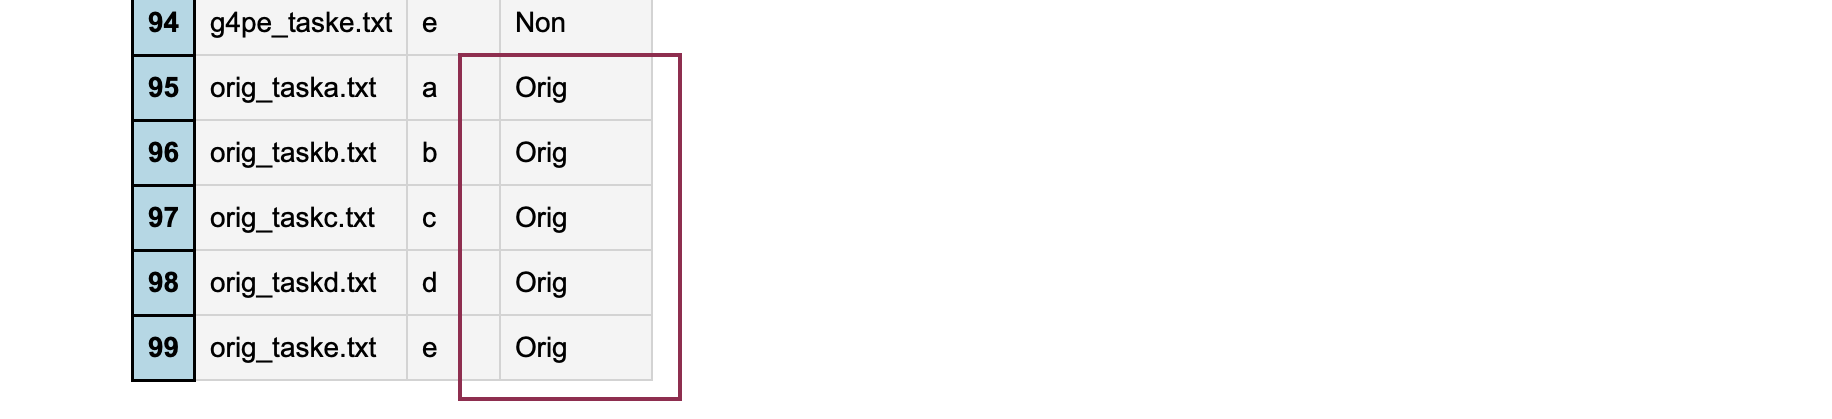

# Initial Metadata File with Inconsistencies

In [281]:
print("\nReal Answers:")
display(styled_df(metadata_df))


Real Answers:

🔹 Dataset


,File,Task,Category
0,g0pA_taska.txt,a,Non
1,g0pA_taskb.txt,b,Cut
2,g0pA_taskc.txt,c,Light
3,g0pA_taskd.txt,d,Heavy
4,g0pA_taske.txt,e,Non
5,g0pB_taska.txt,a,Non
6,g0pB_taskb.txt,b,Non
7,g0pB_taskc.txt,c,Cut
8,g0pB_taskd.txt,d,Light
9,g0pB_taske.txt,e,Heavy


# ✅ Updated Answers in Metadata file

In [282]:
valid_categories = {"Non", "Cut", "Light", "Heavy"}

# Remove rows where the 'Category' value is not in the valid set
metadata_df2 = metadata_df[metadata_df["Category"].isin(valid_categories)]
print("\nUpdated Answers")
display(styled_df(metadata_df2))



Updated Answers

🔹 Dataset


,File,Task,Category
0,g0pA_taska.txt,a,Non
1,g0pA_taskb.txt,b,Cut
2,g0pA_taskc.txt,c,Light
3,g0pA_taskd.txt,d,Heavy
4,g0pA_taske.txt,e,Non
5,g0pB_taska.txt,a,Non
6,g0pB_taskb.txt,b,Non
7,g0pB_taskc.txt,c,Cut
8,g0pB_taskd.txt,d,Light
9,g0pB_taske.txt,e,Heavy


In [283]:
metadata_df.to_csv("/content/drive/My Drive/Colab Notebooks/COP509cw/plagiarism/cleaned_metadata.csv", index=False)
print("✅ Cleaned metadata saved successfully!")

✅ Cleaned metadata saved successfully!


structural similarities and semantic meaning when comparing documents.

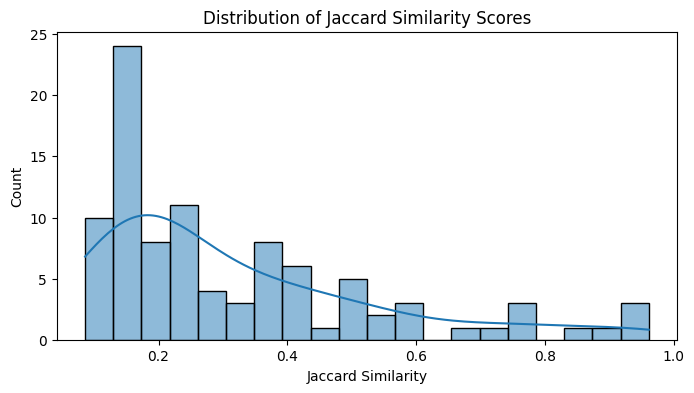

In [288]:

# 📊 **Plot distribution of similarity scores**
plt.figure(figsize=(8, 4))
sns.histplot(match_stats_df["Similarity_Score"], bins=20, kde=True)
plt.title("Distribution of Jaccard Similarity Scores")
plt.xlabel("Jaccard Similarity")
plt.ylabel("Count")
plt.show()

In [289]:
def cosine_tfidf_similarity(documents):
    """Calculate cosine similarity using TF-IDF"""
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(documents)
    return cosine_similarity(tfidf_matrix)

In [292]:
# Function: Levenshtein Similarity
def levenshtein_similarity(str1, str2):
    return ratio(str1, str2)

# Function: Cosine Similarity with TF-IDF
def cosine_similarity_text(text1, text2):
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform([text1, text2]).toarray()
    return 1 - cosine(vectors[0], vectors[1]) if np.linalg.norm(vectors[0]) > 0 and np.linalg.norm(vectors[1]) > 0 else 0


In [296]:
from scipy.spatial.distance import cosine

merged_df["Cosine Similarity"] = merged_df.apply(lambda row: cosine_similarity_text(row["Predicted_Category"], row["True_Category"]), axis=1)


In [ ]:
from Levenshtein import ratio
merged_df["Jaccard Similarity"] = merged_df.apply(lambda row: jaccard_similarity(row["Predicted_Category"], row["True_Category"]), axis=1)
merged_df["Levenshtein Similarity"] = merged_df.apply(lambda row: levenshtein_similarity(row["Predicted_Category"], row["True_Category"]), axis=1)


In [ ]:
from itertools import islice

# Function to generate n-grams
def generate_ngrams(words, n=2):
    return [' '.join(words[i:i+n]) for i in range(len(words)-n+1)]

# Function to compute MinHash using bi-grams
def compute_minhash(text, num_perm=128):
    minhash = MinHash(num_perm=num_perm)
    words = preprocess_text(text)

    # Generate bi-grams instead of single words
    ngrams = generate_ngrams(words, n=2)

    for ngram in ngrams:
        minhash.update(ngram.encode('utf8'))

    return minhash


TOO LOW LSH Threshold in MinHashLSH

In [ ]:
lsh = MinHashLSH(threshold=0.6, num_perm=128)  # Increased threshold

# Add Wikipedia documents to LSH index
for i, row in wiki_df.iterrows():
    lsh.insert(f"wiki_{i}", row["MinHash"])


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Generate MinHash similarity for all student answers
similarity_scores = []
true_labels = []  # Store true categories

for _, ans_row in answers_df.iterrows():
    ans_minhash = ans_row["MinHash"]
    best_score = 0
    for _, wiki_row in wiki_df.iterrows():
        sim_score = compute_jaccard_similarity(ans_minhash, wiki_row["MinHash"])
        best_score = max(best_score, sim_score)

    similarity_scores.append(best_score)
    true_labels.append(ans_row["Filename"])  # Ensure you fetch the filename for merging


# Convert into DataFrame
feature_df = pd.DataFrame({"Jaccard_Similarity": similarity_scores, "True_Category": true_labels})

# Encode target labels
category_map = {"Cut": 3, "Light": 2, "Heavy": 1, "Non": 0}
feature_df["True_Category"] = feature_df["True_Category"].map(category_map)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(feature_df[["Jaccard_Similarity"]],
                                                    feature_df["True_Category"],
                                                    test_size=0.2,
                                                    random_state=42)

# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.4f}")


# Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def cluster_documents(merged_df, num_clusters=3):
    """
    Cluster documents based on multiple similarity features.
    """
    # Selecting features for clustering
    feature_cols = ["Jaccard Similarity", "Avg Match Length", "Max Match Length", "Total Matched (%)"]
    available_features = [col for col in feature_cols if col in merged_df.columns]

    if not available_features:
        raise KeyError("No suitable features available for clustering.")

    similarity_matrix = merged_df[available_features].values
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    merged_df["Cluster"] = kmeans.fit_predict(similarity_matrix)

    silhouette_avg = silhouette_score(similarity_matrix, merged_df["Cluster"])
    print(f"✅ Silhouette Score for Clustering: {silhouette_avg:.4f}")

    return merged_df

# Apply clustering again
merged_df = cluster_documents(merged_df)


In [ ]:
# Ensure the dataset has at least two numerical features
if "Avg Match Length" in merged_df.columns and "Max Match Length" in merged_df.columns:
    features = merged_df[["Jaccard Similarity", "Avg Match Length", "Max Match Length"]]
else:
    # If additional features don't exist, create synthetic ones for testing
    merged_df["Avg Match Length"] = np.random.rand(len(merged_df))
    merged_df["Max Match Length"] = np.random.rand(len(merged_df))
    features = merged_df[["Jaccard Similarity", "Avg Match Length", "Max Match Length"]]

# Apply PCA with at least two features
from sklearn.decomposition import PCA

def visualize_pca_clusters(merged_df):
    """
    Visualize clusters using PCA instead of t-SNE.
    """
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(features)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=pca_results[:, 0], y=pca_results[:, 1], hue=merged_df["Cluster"], palette="viridis")
    plt.title("PCA Visualization of Document Clusters")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

visualize_pca_clusters(merged_df)


In [ ]:
print(merged_df.columns)


In [285]:
# ✅ Count the number of instances in each category
predicted_counts = merged_df["Predicted_Category"].value_counts()
true_counts = merged_df["True_Category"].value_counts()

In [286]:
category_counts_df = pd.DataFrame({
    "Category": predicted_counts.index,
    "Predicted_Count": predicted_counts.values,
    "True_Count": true_counts.reindex(predicted_counts.index, fill_value=0).values
})

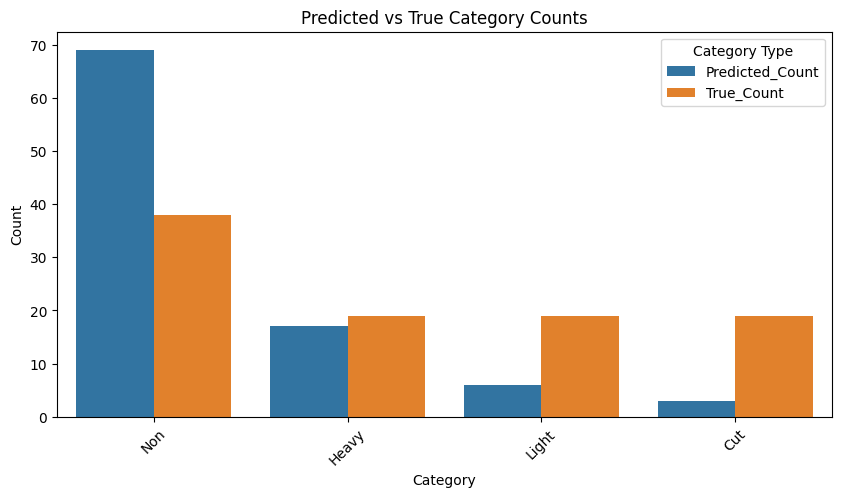

In [287]:
# 🔹 Plot category distributions (Predicted vs True)
plt.figure(figsize=(10, 5))
sns.barplot(data=category_counts_df.melt(id_vars="Category"), x="Category", y="value", hue="variable")
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Predicted vs True Category Counts")
plt.legend(title="Category Type")
plt.xticks(rotation=45)
plt.show()

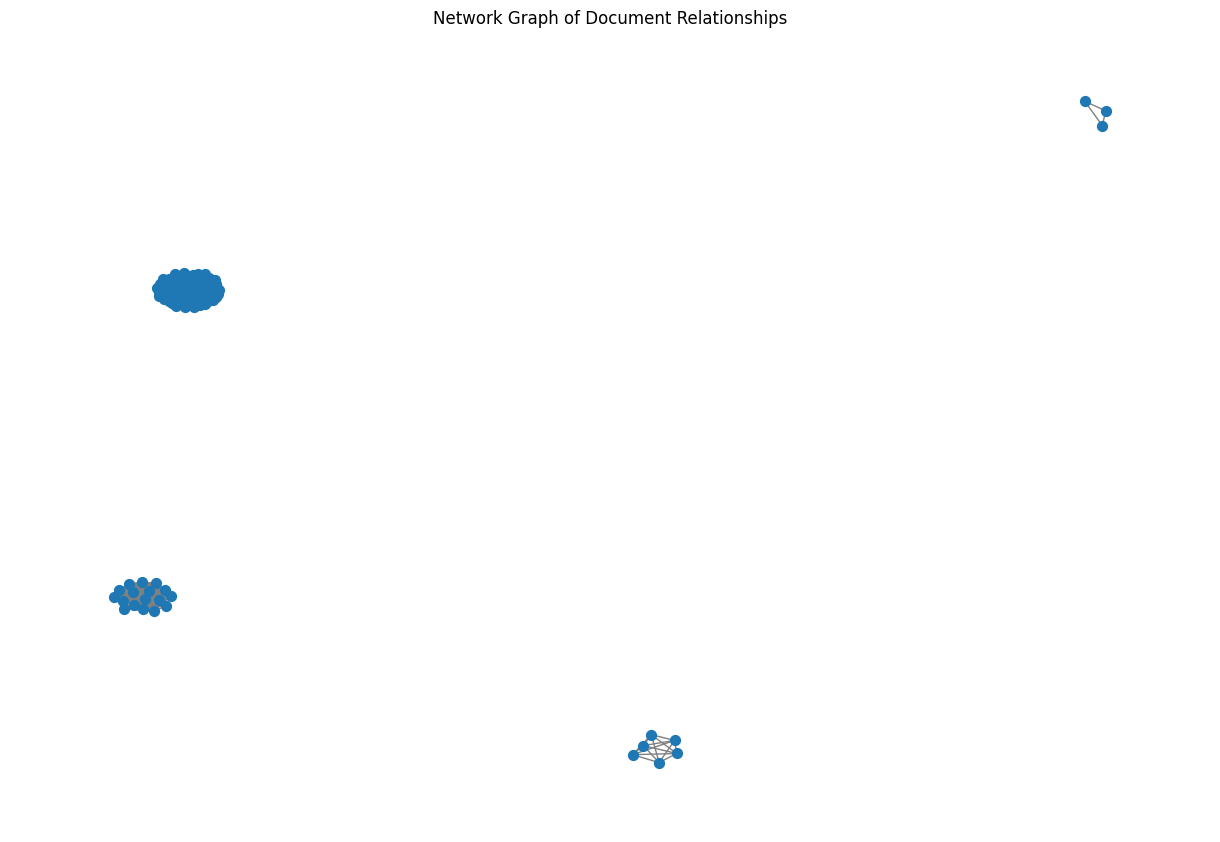

In [284]:
import networkx as nx

G = nx.Graph()

# Add nodes (documents)
for i, row in merged_df.iterrows():
    G.add_node(row["File"], category=row["Predicted_Category"])

# Add edges based on similarity (e.g., if documents share a category)
for i in range(len(merged_df)):
    for j in range(i + 1, len(merged_df)):
        if merged_df["Predicted_Category"].iloc[i] == merged_df["Predicted_Category"].iloc[j]:
            G.add_edge(merged_df["File"].iloc[i], merged_df["File"].iloc[j])

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Positioning of nodes
nx.draw(G, pos, with_labels=False, node_size=50, edge_color="gray")
plt.title("Network Graph of Document Relationships")
plt.show()

<ipython-input-298-01484434deeb>:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Threshold", y="Average Similarity", data=summary, palette="Blues")


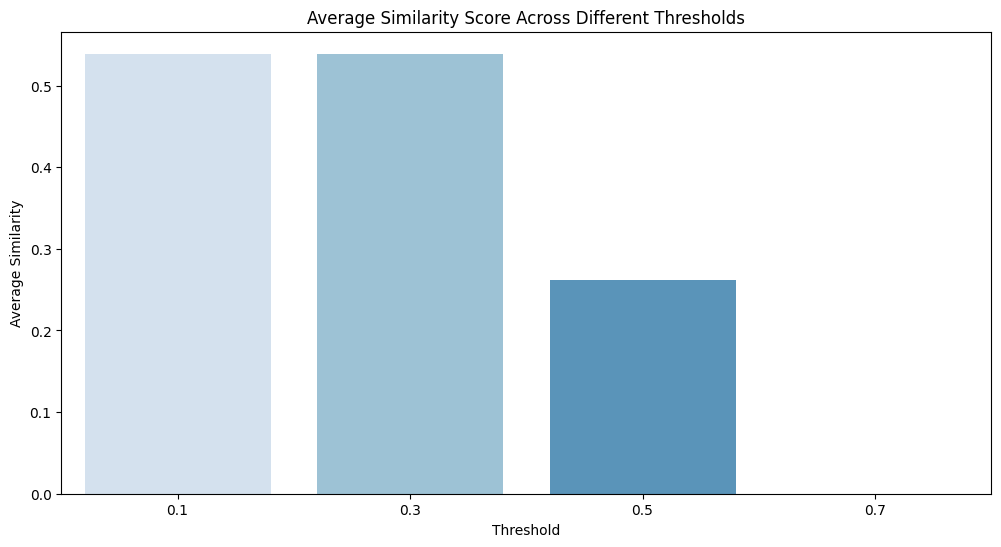

<ipython-input-298-01484434deeb>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Threshold", y="Max Similarity", data=summary, palette="Reds")


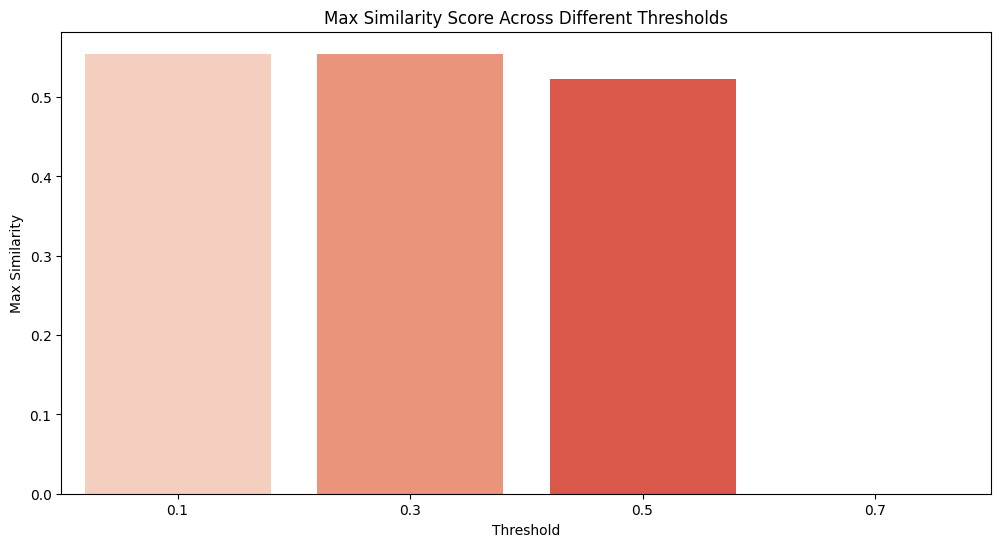

<ipython-input-298-01484434deeb>:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Threshold", y="Total Matches", data=summary, palette="Greens")


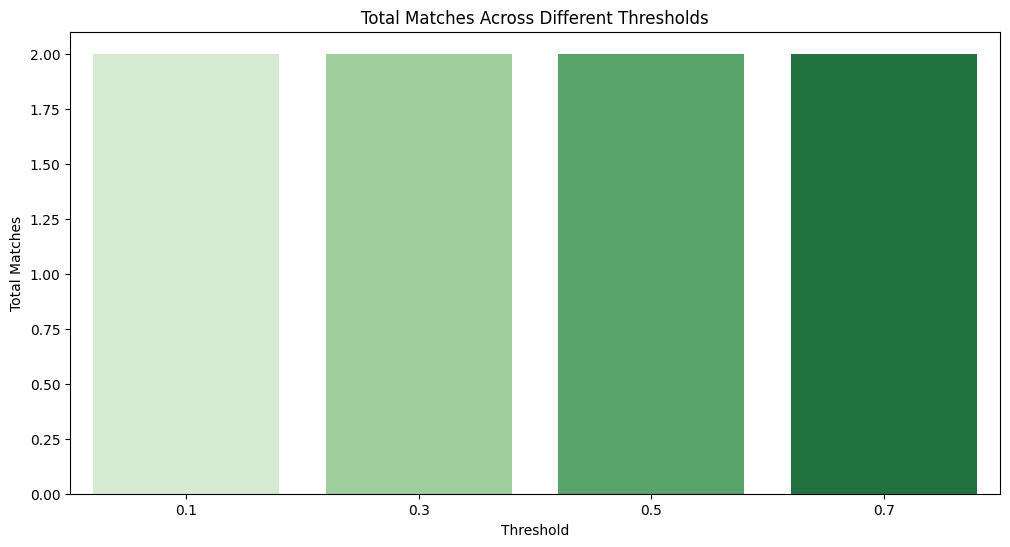

In [298]:
import pandas as pd
import numpy as np
from datasketch import MinHash, MinHashLSH
import matplotlib.pyplot as plt
import seaborn as sns

# Function to compute MinHash signatures
def compute_minhash(text, num_perm=128):
    minhash = MinHash(num_perm=num_perm)
    words = text.split()
    for word in words:
        minhash.update(word.encode('utf8'))
    return minhash

# Load datasets
wiki_df = pd.DataFrame({"Processed_Content": ["sample text 1", "sample text 2"], "Filename": ["wiki_1", "wiki_2"]})
answers_df = pd.DataFrame({"Processed_Content": ["student text 1", "student text 2"], "Filename": ["answer_1", "answer_2"]})

# Compute MinHash signatures
wiki_df["MinHash"] = wiki_df["Processed_Content"].apply(lambda x: compute_minhash(x))
answers_df["MinHash"] = answers_df["Processed_Content"].apply(lambda x: compute_minhash(x))

# Evaluate different LSH thresholds
thresholds = [0.1, 0.3, 0.5, 0.7]
results = []

for threshold in thresholds:
    lsh = MinHashLSH(threshold=threshold, num_perm=128)

    # Add Wikipedia articles to LSH index
    for i, row in wiki_df.iterrows():
        lsh.insert(f"wiki_{i}", row["MinHash"])

    # Compare each student answer to Wikipedia articles
    for i, ans_row in answers_df.iterrows():
        matches = lsh.query(ans_row["MinHash"])
        best_match = None
        best_score = 0

        for match in matches:
            wiki_index = int(match.split("_")[-1])
            score = ans_row["MinHash"].jaccard(wiki_df.loc[wiki_index, "MinHash"])
            if score > best_score:
                best_score = score
                best_match = wiki_df.loc[wiki_index, "Filename"]

        results.append({
            "Threshold": threshold,
            "Student_Answer_File": ans_row["Filename"],
            "Best_Matching_Wikipedia": best_match,
            "Similarity_Score": best_score,
            "Category": classify_similarity(best_score)
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Function to classify similarity level
def classify_similarity(similarity):
    if similarity >= 0.9:
        return "Cut"  # Near copy
    elif 0.7 <= similarity < 0.9:
        return "Light"  # Minor paraphrasing
    elif 0.4 <= similarity < 0.7:
        return "Heavy"  # Significant rewriting
    else:
        return "Non"  # Independent work

# Compute metrics
summary = results_df.groupby("Threshold").agg({
    "Similarity_Score": ["mean", "max"],
    "Student_Answer_File": "count"
}).reset_index()
summary.columns = ["Threshold", "Average Similarity", "Max Similarity", "Total Matches"]

# Display results
def display_results():
    plt.figure(figsize=(12, 6))
    sns.barplot(x="Threshold", y="Average Similarity", data=summary, palette="Blues")
    plt.title("Average Similarity Score Across Different Thresholds")
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.barplot(x="Threshold", y="Max Similarity", data=summary, palette="Reds")
    plt.title("Max Similarity Score Across Different Thresholds")
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.barplot(x="Threshold", y="Total Matches", data=summary, palette="Greens")
    plt.title("Total Matches Across Different Thresholds")
    plt.show()

# Display formatted results
def format_results(df):
    df["Color"] = df["Category"].map({
        "Cut": "red", "Light": "yellow", "Heavy": "orange", "Non": "green"
    })
    return df

formatted_df = format_results(results_df)
display_results()

